# Sentiment analysis: Research Investigation

In [ ]:
__author__ = "Shubham Chowdhary"
__version__ = "Original System, XCS224u, Stanford, Spring 2021"

In [1]:
# Mount colab drive
# import os
#
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     from google.colab import drive
#     drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# verify python and gpu status
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     !pwd
#     %cd /content/drive/MyDrive/MLDL/stanfordXCS224U/referenceRepo/cs224u
#     !python --version
#     !nvidia-smi

/content
/content/drive/MyDrive/MLDL/stanfordXCS224U/referenceRepo/cs224u
Python 3.7.11
Sun Sep 12 15:33:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+


In [4]:
# install pytorch 1.8-gpu
# if 'IS_GRADESCOPE_ENV' not in os.environ:
    # !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
# install transformers 4.3.3 (works only after a retart of runtime if the pytorch package is freshly installed)
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     !pip install transformers==4.3.3

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 74.8 MB/s 
     |████████████████████████████████| 3.3 MB 34.6 MB/s 


In [6]:
# verify python, pytorch, and tranformers package version
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
    !python --version
    !pip show torch
    print("")
    !pip show transformers
    print("")
    import torch
    print(torch.cuda.get_device_name(0))

Python 3.7.11
Name: torch
Version: 1.9.0+cu102
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, fastai

Name: transformers
Version: 4.3.3
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /usr/local/lib/python3.7/dist-packages
Requires: filelock, requests, regex, tqdm, packaging, sacremoses, numpy, tokenizers, importlib-metadata
Required-by: 

Tesla P100-PCIE-16GB


In [7]:
from collections import Counter
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch.nn as nn

from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import sst
import utils

In [8]:
SST_HOME = os.path.join('data', 'sentiment')

## Train set

Our primary train set is the SST-3 train set:

In [9]:
sst_train = sst.train_reader(SST_HOME)

In [10]:
sst_train.shape[0]

8544

## Dev sets

We have two development set. SST3-dev consists of sentences from movie reviews, just like SST-3 train:

In [12]:
sst_dev = sst.dev_reader(SST_HOME)

The bakeoff dev set consists of sentences from restaurant reviews:

In [13]:
bakeoff_dev = sst.bakeoff_dev_reader(SST_HOME)

In [14]:
bakeoff_dev.sample(3, random_state=1).to_dict(orient='records')

[{'example_id': 57,
  'is_subtree': 0,
  'label': 'neutral',
  'sentence': 'I would recommend that you make reservations in advance.'},
 {'example_id': 590,
  'is_subtree': 0,
  'label': 'positive',
  'sentence': 'We were welcomed warmly.'},
 {'example_id': 1968,
  'is_subtree': 0,
  'label': 'neutral',
  'sentence': 'We have been to Oceanaire twice in the last 6 weeks.'}]

Here is the label distribution:

In [15]:
bakeoff_dev.label.value_counts()

neutral     1019
positive     777
negative     565
Name: label, dtype: int64

The label distribution for the corresponding test set is similar to this.

## A softmax baseline

In [ ]:
def unigrams_phi(text):
    return Counter(text.split())

Thin wrapper around `LogisticRegression` for the sake of `sst.experiment`:

In [ ]:
def fit_softmax_classifier(X, y):
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr')
    mod.fit(X, y)
    return mod

The experimental run with some notes:

In [ ]:
softmax_experiment = sst.experiment(
    sst.train_reader(SST_HOME),
    unigrams_phi,
    fit_softmax_classifier,
    assess_dataframes=[sst_dev, bakeoff_dev])

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.628     0.689     0.657       428
     neutral      0.343     0.153     0.211       229
    positive      0.629     0.750     0.684       444

    accuracy                          0.602      1101
   macro avg      0.533     0.531     0.518      1101
weighted avg      0.569     0.602     0.575      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.272     0.690     0.390       565
     neutral      0.429     0.113     0.179      1019
    positive      0.409     0.346     0.375       777

    accuracy                          0.328      2361
   macro avg      0.370     0.383     0.315      2361
weighted avg      0.385     0.328     0.294      2361

Mean of macro-F1 scores: 0.416


**_SST dev score: 0.518_**

## RNNClassifier wrapper

To featurize examples for an RNN, we can just get the words in order, letting the model take care of mapping them into an embedding space.

In [ ]:
def rnn_phi(text):
    return text.split()

In [ ]:
def fit_rnn_classifier(X, y):
    sst_glove_vocab = utils.get_vocab(X, mincount=2)
    mod = TorchRNNClassifier(
        sst_glove_vocab,
        early_stopping=True)
    mod.fit(X, y)
    return mod

In [ ]:
rnn_experiment = sst.experiment(
    sst.train_reader(SST_HOME),
    rnn_phi,
    fit_rnn_classifier,
    vectorize=False,  # For deep learning, use `vectorize=False`.
    assess_dataframes=[sst_dev, bakeoff_dev])

Stopping after epoch 82. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.07533295871689916

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.621     0.577     0.598       428
     neutral      0.266     0.336     0.297       229
    positive      0.617     0.574     0.595       444

    accuracy                          0.526      1101
   macro avg      0.501     0.496     0.497      1101
weighted avg      0.545     0.526     0.534      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.279     0.361     0.315       565
     neutral      0.476     0.342     0.398      1019
    positive      0.410     0.475     0.440       777

    accuracy                          0.390      2361
   macro avg      0.389     0.392     0.384      2361
weighted avg      0.407     0.390     0.392      2361

Mean of macro-F1 scores: 0.440


**_SST dev score: 0.475_**

## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'phi': the feature function used
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_datasets': list of datasets, each with the same structure as the value of 'train_dataset'
'predictions': list of lists of predictions on the assessment datasets
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the each of the assessment dataasets
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [182]:
def find_errors(experiment):
    """Find mistaken predictions.

    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.

    Returns
    -------
    pd.DataFrame

    """
    dfs = []
    for i, dataset in enumerate(experiment['assess_datasets']):
        df = pd.DataFrame({
            'raw_examples': dataset['raw_examples'],
            'predicted': experiment['predictions'][i],
            'gold': dataset['y']})
        df['correct'] = df['predicted'] == df['gold']
        df['dataset'] = i
        dfs.append(df)
    return pd.concat(dfs)

In [ ]:
softmax_analysis = find_errors(softmax_experiment)

In [ ]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the softmax and RNN experiments into a single DataFrame:

In [ ]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

In [ ]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])
    &
    (analysis['gold'] == 'positive')
]

In [ ]:
error_group.shape[0]

210

In [ ]:
for ex in error_group['raw_examples'].sample(5, random_state=1):
    print("="*70)
    print(ex)

That is a compliment to Kuras and Miller .
We tried a couple of the new items on the menu and the manager even came by to ask us for feedback.
Martin and Barbara are complex characters -- sometimes tender , sometimes angry -- and the delicate performances by Sven Wollter and Viveka Seldahl make their hopes and frustrations vivid .
Ok, I love good food and good service wghich was provited at Mortons Sat.
Thanks to Scott 's charismatic Roger and Eisenberg 's sweet nephew , Roger Dodger is one of the most compelling variations on In the Company of Men .


### A more powerful vector-averaging baseline

In [16]:
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier

def fit_shallow_neural_classifier_with_hyperparameter_search(X, y):
    basemod = TorchShallowNeuralClassifier(
        early_stopping=True)
    cv = 3
    param_grid = {
        'hidden_dim': [50, 100, 200],
        'hidden_activation': [nn.Tanh(), nn.ReLU()]}
    
    bestmod = utils.fit_classifier_with_hyperparameter_search(
        X, y, basemod, cv, param_grid)
    
    return bestmod


In [ ]:
# testing the above fit against the logistic regression performance
if 'IS_GRADESCOPE_ENV' not in os.environ:
    DATA_HOME = 'data'
    GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

    glove_lookup = utils.glove2dict(
        os.path.join(GLOVE_HOME, 'glove.6B.300d.txt'))
    
    def vsm_phi(text, lookup, np_func=np.mean):
        """Represent `tree` as a combination of the vector of its words.

        Parameters
        ----------
        text : str

        lookup : dict
            From words to vectors.

        np_func : function (default: np.sum)
            A numpy matrix operation that can be applied columnwise,
            like `np.mean`, `np.sum`, or `np.prod`. The requirement is that
            the function take `axis=0` as one of its arguments (to ensure
            columnwise combination) and that it return a vector of a
            fixed length, no matter what the size of the tree is.

        Returns
        -------
        np.array, dimension `X.shape[1]`

        """
        allvecs = np.array([lookup[w] for w in text.split() if w in lookup])
        if len(allvecs) == 0:
            dim = len(next(iter(lookup.values())))
            feats = np.zeros(dim)
        else:
            feats = np_func(allvecs, axis=0)
        return feats

    def glove_phi(text, np_func=np.mean):
        return vsm_phi(text, glove_lookup, np_func=np_func)

    shallow_nn_classifier_opt_glv_phi_experiment = sst.experiment(
        sst_train,
        glove_phi,
        fit_shallow_neural_classifier_with_hyperparameter_search,
        assess_dataframes=sst_dev,
        vectorize=False)

Stopping after epoch 40. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 5.844003677368164

Best params: {'hidden_activation': ReLU(), 'hidden_dim': 200}
Best score: 0.535
              precision    recall  f1-score   support

    negative      0.614     0.736     0.670       428
     neutral      0.510     0.114     0.186       229
    positive      0.637     0.770     0.697       444

    accuracy                          0.620      1101
   macro avg      0.587     0.540     0.517      1101
weighted avg      0.602     0.620     0.580      1101



An hyperparameter optimized shallow NN performs better than a Linear Classifier on GloVe mean-aggregated sentence represenations. **Improved from 0.48 macro-f1 score for the later to 0.534 for the former.**

### BERT encoding

In [23]:
from transformers import BertModel, BertTokenizer
import vsm

bert_weights_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
bert_model = BertModel.from_pretrained(bert_weights_name)

def hf_cls_phi(text):
    text_bert_ids = vsm.hf_encode(text, bert_tokenizer,
                                   add_special_tokens=True)

    text_bert_reps = vsm.hf_represent(text_bert_ids, bert_model, layer=-1)

    text_aggr_bert_rep = text_bert_reps[0, 0, :]

    return text_aggr_bert_rep.cpu().numpy()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# experimental test to verify if bert repr would perform better than GloVe's
if 'IS_GRADESCOPE_ENV' not in os.environ:

    def hf_cls_phi_tensor(text):
        text_bert_ids = vsm.hf_encode(text, bert_tokenizer, add_special_tokens=True)
        text_bert_reps = vsm.hf_represent(text_bert_ids, bert_model, layer=-1)
        text_aggr_bert_rep = text_bert_reps[0, 0, :]
        return text_aggr_bert_rep.numpy()


    shallow_nn_classifier_opt_bert_cls_phi_experiment = sst.experiment(
        sst_train,
        hf_cls_phi_tensor,
        fit_shallow_neural_classifier_with_hyperparameter_search,
        assess_dataframes=sst_dev,
        vectorize=False)

Stopping after epoch 33. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 4.920585095882416

Best params: {'hidden_activation': ReLU(), 'hidden_dim': 100}
Best score: 0.604
              precision    recall  f1-score   support

    negative      0.729     0.752     0.740       428
     neutral      0.371     0.170     0.234       229
    positive      0.693     0.865     0.770       444

    accuracy                          0.677      1101
   macro avg      0.598     0.596     0.581      1101
weighted avg      0.640     0.677     0.647      1101



The results show that the bert based feature vectors perform better than the GloVe feature vectors, when the fit model (shallow neural network) and the hyper-parameter search space is kept the same. **A gain from 0.50 to 0.609.** 

### The Original system

There are various ways in which we can explore this problem. Exploring all of the ideas/variations in a short span is also not feasible. Hence, we list certain subsections/ideas where we feel an **improvement** is possible. Then we will work on all/many of those depending on time constraints.

1. Its almost certain that including a training data set from the restaurant/product review will contribute to the performance on dev/test sets we have. **We will try to include the dynasent dataset.**
2. **Training on sub-sentences and their labels** is again an extremely great way to improve on sentiment analysis.
3. Various ways in which we can **extract/construct feature vectors** from the sentences.
4. Various ways in which we can fit these features for the corresponding sentiment response (various models + various **hyperparameters**). 

#### 1. Additional Datasets (DynaSent)

We try including the dynasent (yelp-based) restaurant/product review dataset

In [17]:
# loading dynasent dataset (revision 1).
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import json

    def load_dataset(*src_filenames, labels=None):
        data = []
        for filename in src_filenames:
            with open(filename) as f:
                for line in f:
                    d = json.loads(line)
                    if labels is None or d['gold_label'] in labels:
                        data.append(d)
        return data
    
    r1_train_filename = os.path.join(SST_HOME, 'dynasent-v1.1', 'dynasent-v1.1-round01-yelp-train.jsonl')
    r2_train_filename = os.path.join(SST_HOME, 'dynasent-v1.1', 'dynasent-v1.1-round02-dynabench-train.jsonl')
    ternary_labels = ('positive', 'negative', 'neutral')

    r1_train = load_dataset(r1_train_filename, labels=ternary_labels)
    r2_train = load_dataset(r2_train_filename, labels=ternary_labels)
    # X_train, y_train = zip(*[(d['sentence'], d['gold_label']) for d in r1_train])

    dsent_train = pd.DataFrame(columns = ["sentence", "label"])

    for d in r1_train:
        if(len(d['sentence']) > 512):
            continue
        dsent_train = dsent_train.append({'sentence': d['sentence'], 'label': d['gold_label']}, ignore_index = True)
        
    for d in r2_train:
        if(len(d['sentence']) > 512):
            continue
        dsent_train = dsent_train.append({'sentence': d['sentence'], 'label': d['gold_label']}, ignore_index = True)

    print(dsent_train.head())

                                            sentence     label
0  Roto-Rooter is always good when you need someo...  positive
1  It's so worth the price of cox service over he...  positive
2  I placed my order of "sticky ribs" as an appet...   neutral
3  There is mandatory valet parking, so make sure...   neutral
4                  My wife and I couldn't finish it.   neutral


In [ ]:
# running a sample experiment on it to make sure it works with our pipeline
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     softmax_classifier_unigram_phi_exp = sst.experiment(
#         dsent_train,
#         unigrams_phi,
#         fit_softmax_classifier,
#         assess_dataframes=[sst_dev, bakeoff_dev])

As per our expectation, **_the score is good for the dataset 2, but bad on the sst dataset (dataset 1)_**, when using only the dsent_train. This will later be good for both when we train on both type of datasets. So the score can be improved simply by augmenting the dataset too. The other optimisations are a "plus" to this.

**_A look on the dynasent dataset_**

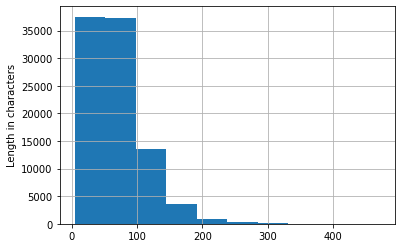

In [112]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    _ = dsent_train.sentence.str.len().hist().set_ylabel("Length in characters")

**_Some samples need to be trimmed here as bert does not except sentences beyond 512 characters._**

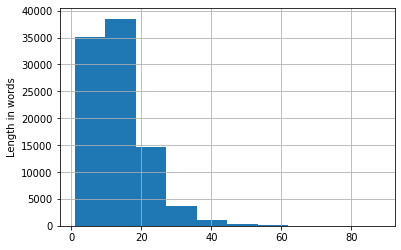

In [113]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    dsent_train['word_count'] = dsent_train.sentence.str.split().apply(len)

    _ = dsent_train['word_count'].hist().set_ylabel("Length in words")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


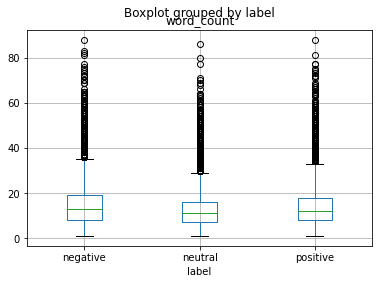

In [115]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    _ = dsent_train.boxplot("word_count", by="label")

**_Many outliers in this dataset_**

Since we know that including subtrees from SST dataset almost anyways leads to a performance improvement, we will definitely make this optimization on the dataset. Although, we prefer to do this later, during the research for a good model. This is because any model trained on all the subtrees takes exceptional amount of training time. **_This saves the compute resources during the research_**.

#### 2.1. Tokenizer, Sentiment-based

Lets use a sentiment aware tokenizer and see its gains. If possible, lets see if performance improves on negation/parts of speech tagging

In [202]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from nltk.tokenize import TweetTokenizer
    tknzr = TweetTokenizer(preserve_case=False)

    def tweet_token_ctr_phi(text):
        return Counter(tknzr.tokenize(text))
    
    def tweet_token_phi(text):
        return tknzr.tokenize(text)

In [ ]:
# Lets see how it performs. This might suggest complex meanings (as it is a sentiment based tokenization), 
# and hence lets try using a non-linear model's performance as a baseline for it

if 'IS_GRADESCOPE_ENV' not in os.environ:
    shallow_nn_classifier_opt_tweet_token_ctr_phi_experiment = sst.experiment(
            sst_train,
            tweet_token_ctr_phi,
            fit_shallow_neural_classifier_with_hyperparameter_search,
            assess_dataframes=[sst_dev, bakeoff_dev],
            vectorize=True)

Stopping after epoch 26. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.1551160365343094

Best params: {'hidden_activation': ReLU(), 'hidden_dim': 50}
Best score: 0.530
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.633     0.654     0.644       428
     neutral      0.252     0.140     0.180       229
    positive      0.639     0.766     0.697       444

    accuracy                          0.592      1101
   macro avg      0.508     0.520     0.507      1101
weighted avg      0.556     0.592     0.569      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.303     0.600     0.403       565
     neutral      0.449     0.178     0.255      1019
    positive      0.471     0.510     0.489       777

    accuracy                          0.388      2361
   macro avg      0.408     0.429     0.382      2361
weighted avg      0.421     0.388     0.367      2361

Mean of macro-F1 scores: 0.445


We consider a Shallow Neural Network a preliminary non-linear baseline for any peripheral optimization we do with the experiment. **_We assume that if a simple NN with some non linearity can fit a complex relationship to some extent, then complex models like RNN/LSTM would be capalble of the same, maybe even more._** **_SST dev score: 0.521_**

#### 2.2. Tokenizer, Negation-based
With the use of regex from references [from Chris Potts' work](http://sentiment.christopherpotts.net/lingstruc.html#approach), we are trying to build a negation tokenizer

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import regex as re

    # not so perfect regex, but suffices our cause
    neg_string = r"""
            \b(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint)|n't
            \b[\w\s]+[^\w\s]"""
    
    neg_regex = re.compile(neg_string, re.VERBOSE | re.I | re.UNICODE)

    def tweet_token_neg_phi(text):
        s = re.sub(neg_regex, 
                                 lambda match: re.sub(r'(\s+)(\w+)', r'\1\2_NEG', match.group(0)),
                                 text)
        return tweet_token_phi(s)

    def tweet_token_neg_ctr_phi(text):
        s = re.sub(neg_regex, 
                                 lambda match: re.sub(r'(\s+)(\w+)', r'\1\2_NEG', match.group(0)),
                                 text)
        return tweet_token_ctr_phi(s)
    
    print(tweet_token_neg_phi("I mightn't go to school."))



['i', "mightn't", 'go_neg', 'to_neg', 'school_neg', '.']


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    shallow_nn_classifier_opt_tweet_token_neg_ctr_phi_experiment = sst.experiment(
            sst_train,
            tweet_token_neg_ctr_phi,
            fit_shallow_neural_classifier_with_hyperparameter_search,
            assess_dataframes=[sst_dev, bakeoff_dev],
            vectorize=True)

Stopping after epoch 26. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.3303545117378235

Best params: {'hidden_activation': Tanh(), 'hidden_dim': 200}
Best score: 0.546
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.629     0.680     0.653       428
     neutral      0.306     0.166     0.215       229
    positive      0.650     0.752     0.697       444

    accuracy                          0.602      1101
   macro avg      0.528     0.533     0.522      1101
weighted avg      0.570     0.602     0.580      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.298     0.625     0.404       565
     neutral      0.428     0.170     0.243      1019
    positive      0.477     0.475     0.476       777

    accuracy                          0.379      2361
   macro avg      0.401     0.423     0.374      2361
weighted avg      0.413     0.379     0.358      2361

Mean of macro-F1 scores: 0.448


**_NEG tagging + sentiment tokenizer works a tad better than simple sentiment tokenizer_**. Other recurrent/sequence models like RNN/LSTM/BERT will, through context, learn this negation concept anyways. Moreover, **_this regex does not work with multiple nested negations. it also does not work with casual words like "dont" instead of "don't"._** We might still still proceed with it, but we keep, plain sentiment-token in the pipeline too. **_SST dev score: 0.519_**

#### 2.3 Tokenizer, n-gram phi?
Lets see if there is an advantage over a unigram phi

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    from nltk import ngrams
    
    def multigram_phi(text):
        n_gram_factor = 2
        n_grams = ngrams(text.split(), n_gram_factor)
        
        n_grams_list = [n_gram for n_gram in n_grams]
        return n_grams_list
    
    def multigram_tweet_token_phi(text):
        n_gram_factor = 2
        n_grams = ngrams(tweet_token_phi(text), n_gram_factor)
        n_grams_list = [n_gram for n_gram in n_grams]
        return n_grams_list
    
    def multigram_tweet_token_ctr_phi(text):
        return Counter(multigram_tweet_token_phi(text))
    
    print(multigram_tweet_token_ctr_phi("I want to go to school today."))

Counter({('i', 'want'): 1, ('want', 'to'): 1, ('to', 'go'): 1, ('go', 'to'): 1, ('to', 'school'): 1, ('school', 'today'): 1, ('today', '.'): 1})


In [ ]:
# trying to guage a bi-gram's performance (***EXTREMELY MEMORY INTENSIVE***)
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     shallow_nn_classifier_opt_multigram_tweet_token_ctr_phi_experiment = sst.experiment(
#             sst_train,
#             multigram_tweet_token_ctr_phi,
#             fit_shallow_neural_classifier_with_hyperparameter_search,
#             assess_dataframes=[sst_dev, bakeoff_dev],
#             vectorize=True)

Bi-grams and other n > 2 grams seem to be quite promising. But they have a ramped up memory requirement. For example here, for an L length sentence, there will be L-1 bi-grams and while there might be repeated unigrams in a sentence, it is **extremely rare** to find repeated 2-grams. Hence, the size of the feature matrix will almost always remain ~ O(L), which suggests that this works more like **rote-learning**. Sufficient dataset inference from this kind of model should provide **good performance**, but that would never justify the huge memory requirements it has. 

As a practical example, **the above cell crashes even the ColabPro runtime**. Hence, not proceeding with multi-grams in our setup.

#### 2.4 VSM from word_relatedness
It looks like a good idea to use feature vectors from the VSMs created in the word_relatedness work. Since it performed well, the representations from it can be quite promising.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    VSM_HOME = os.path.join('data', 'vsmdata')

    def create_df_vsm():
        full_matrix_df = pd.read_csv(os.path.join(VSM_HOME, "best_devset_word_repr_vsm.csv.gz"), index_col=0)
        return full_matrix_df
    
    custom_vsm = create_df_vsm()

    custom_vsm_lookup = {word:custom_vsm.loc[word] for word in custom_vsm.index}
    
    print(custom_vsm_lookup["water"])
    

0       0.007726
1      -0.002936
2       0.001923
3      -0.002022
4       0.029006
          ...   
1275    0.009053
1276   -0.020875
1277    0.027672
1278    0.033489
1279    0.011569
Name: water, Length: 1280, dtype: float64


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    def custom_vsm_phi(text):
        text_list = text.split()
        text_repr = []
        repr_dim = len(custom_vsm.columns)
        
        text_repr = [list(custom_vsm.loc[word])  
                      for word in text_list if word in custom_vsm.index]
        
        if len(text_repr) == 0:
            text_repr = np.zeros(repr_dim)
            return text_repr
        
        return np.mean(text_repr, axis=0)
    
    print(custom_vsm_phi("water is the new game"))



[-0.00461155 -0.00676014  0.00023683 ...  0.00576954  0.01061944
  0.00043484]


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    shallow_nn_classifier_opt_custom_vsm_phi_experiment = sst.experiment(
            sst_train,
            custom_vsm_phi,
            fit_shallow_neural_classifier_with_hyperparameter_search,
            assess_dataframes=[sst_dev, bakeoff_dev],
            vectorize=False)

Stopping after epoch 61. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 6.368035912513733

Best params: {'hidden_activation': ReLU(), 'hidden_dim': 200}
Best score: 0.469
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.625     0.696     0.659       428
     neutral      0.304     0.031     0.056       229
    positive      0.592     0.802     0.681       444

    accuracy                          0.600      1101
   macro avg      0.507     0.510     0.465      1101
weighted avg      0.545     0.600     0.542      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.296     0.761     0.426       565
     neutral      0.456     0.091     0.152      1019
    positive      0.457     0.414     0.435       777

    accuracy                          0.358      2361
   macro avg      0.403     0.422     0.338      2361
weighted avg      0.418     0.358     0.311      2361

Mean of macro-F1 scores: 0.401


The scores from the *limited vocabulary VSM* we created then, could not very well encode the sentences. This might majorly be because of a lack of vast vocabulary in it. Not proceeding with this in the pipeline further.

#### **2.5 Pipeline till now**:
1. Use **_dsent_train + sst_train (issubtree=True)_**
2. Feature vectorization using: **_tweet_token_phi_**, glove_phi, tweet_token_neg_phi, **_bert pretrained embeddings_**, randomly inited embeddings
3. Now let us explore various fit models 

#### 3. Various models (with hyper-param optimizations)

##### 3.1 SGDClassifier

In [ ]:
# sklearn's SGD Classifier

if 'IS_GRADESCOPE_ENV' not in os.environ:

    from sklearn.linear_model import SGDClassifier

    def fit_sgdclassifier_with_hyperparameter_search(X, y):
        basemod = SGDClassifier(tol=1e-4, n_jobs=-1, 
            early_stopping=True)
        cv = 5
        param_grid = {
            'loss': ['hinge', 'log', 'modified_huber'],
            'penalty': ['l1', 'l2']}
        
        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv, param_grid)
        
        return bestmod


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    sgdclassifier_opt_tweet_token_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_sgdclassifier_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Best params: {'loss': 'log', 'penalty': 'l1'}
Best score: 0.517
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.605     0.540     0.570       428
     neutral      0.264     0.262     0.263       229
    positive      0.604     0.669     0.635       444

    accuracy                          0.534      1101
   macro avg      0.491     0.490     0.489      1101
weighted avg      0.533     0.534     0.532      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.322     0.473     0.383       565
     neutral      0.470     0.344     0.398      1019
    positive      0.457     0.462     0.460       777

    accuracy                          0.414      2361
   macro avg      0.416     0.426     0.413      2361
weighted avg      0.430     0.414     0.415      2361

Mean of macro-F1 scores: 0.451


**_SST dev score: 0.489_**

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    sgdclassifier_opt_tweet_token_neg_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_neg_ctr_phi,
        fit_sgdclassifier_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Best params: {'loss': 'modified_huber', 'penalty': 'l1'}
Best score: 0.519
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.639     0.579     0.608       428
     neutral      0.289     0.245     0.265       229
    positive      0.601     0.703     0.648       444

    accuracy                          0.559      1101
   macro avg      0.510     0.509     0.507      1101
weighted avg      0.551     0.559     0.553      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.318     0.467     0.378       565
     neutral      0.466     0.309     0.372      1019
    positive      0.448     0.493     0.470       777

    accuracy                          0.407      2361
   macro avg      0.411     0.423     0.407      2361
weighted avg      0.425     0.407     0.405      2361

Mean of macro-F1 scores: 0.457


**_SST dev score: 0.507_**

The linear classifiers dont perform extremely well, but **_after some optimization they reach a value around 0.51_**.

##### 3.2 Logistic Regression

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from sklearn.linear_model import LogisticRegression

    def fit_logistic_with_hyperparameter_search(X, y):
        basemod = LogisticRegression(tol=1e-4)
        cv = 5
        param_grid = {
            # newton-cg, saga are quite slow and should not contribute 
            # much to the score anyways
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': [0.5, 1, 2]}
        
        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv, param_grid)
        
        return bestmod

    def fit_logistic_with_hyperparameter_search_2(X, y):
        basemod = LogisticRegression(tol=1e-4, max_iter=1000)
        cv = 5
        param_grid = {
            'solver': ['lbfgs'],
            'penalty': ['l2'],
            'C': [0.5, 1, 2]}
        
        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv, param_grid)
        
        return bestmod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    logistic_opt_tweet_token_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_logistic_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Best params: {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.526
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.620     0.666     0.642       428
     neutral      0.304     0.153     0.203       229
    positive      0.631     0.748     0.685       444

    accuracy                          0.592      1101
   macro avg      0.518     0.522     0.510      1101
weighted avg      0.559     0.592     0.568      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.287     0.611     0.390       565
     neutral      0.426     0.146     0.218      1019
    positive      0.465     0.484     0.474       777

    accuracy                          0.368      2361
   macro avg      0.393     0.414     0.361      2361
weighted avg      0.405     0.368     0.343      2361

Mean of macro-F1 scores: 0.435


**_SST dev score: 0.510_**

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    logistic_opt_tweet_token_ctr_phi_experiment_2 = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_logistic_with_hyperparameter_search_2,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Best params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.530
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.620     0.666     0.642       428
     neutral      0.289     0.153     0.200       229
    positive      0.631     0.739     0.680       444

    accuracy                          0.589      1101
   macro avg      0.513     0.519     0.507      1101
weighted avg      0.555     0.589     0.566      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.293     0.627     0.399       565
     neutral      0.410     0.145     0.214      1019
    positive      0.468     0.476     0.472       777

    accuracy                          0.369      2361
   macro avg      0.390     0.416     0.362      2361
weighted avg      0.401     0.369     0.343      2361

Mean of macro-F1 scores: 0.435


SST dev score: 0.507 , **_not much gains with the second-derivate estimates_**

##### 3.3 SVM

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from sklearn.svm import SVC

    def fit_svm_with_hyperparameter_search(X, y):
        basemod = SVC(tol=1e-4, class_weight='balanced', C=1, kernel='rbf',
                      probability=False)
        basemod.fit(X, y)
        return basemod
        # cv = 5
        # param_grid = {
        #     'C': [0.5, 1, 2],
        #     'kernel': ['poly', 'rbf'],
        #     'probability': [False]}
        
        # bestmod = utils.fit_classifier_with_hyperparameter_search(
        #     X, y, basemod, cv, param_grid)
        
        # return bestmod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    svm_opt_tweet_token_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_svm_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.633     0.610     0.621       428
     neutral      0.296     0.288     0.292       229
    positive      0.650     0.682     0.666       444

    accuracy                          0.572      1101
   macro avg      0.527     0.527     0.526      1101
weighted avg      0.570     0.572     0.571      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.291     0.414     0.342       565
     neutral      0.434     0.472     0.452      1019
    positive      0.487     0.281     0.356       777

    accuracy                          0.395      2361
   macro avg      0.404     0.389     0.383      2361
weighted avg      0.417     0.395     0.394      2361

Mean of macro-F1 scores: 0.455


This is an extremely costly step. **_It took 45 min just to train 1 variant!!! This must be because of the O(n^2) approach on the data points it takes. Anyways, because the model as some of the top scores, it can be included for further investigation._** But its not possible to optimiza on its hyperparameters for now. **_Since it cannot be trained on a large dataset (SST+dynasent) without incurring a lot of CPU-only compute time, we still need to see if we want to include this model for the final evaluation._**

**_SST dev score: 0.526_**

##### 3.4 Multinomial NB

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from sklearn.naive_bayes import MultinomialNB

    # the few hyper-parameters it has are okay in their defaults
    def fit_nb(X, y):
        mod = MultinomialNB()
        mod.fit(X, y)
        return mod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    nb_tweet_token_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_nb,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.632     0.757     0.689       428
     neutral      0.357     0.044     0.078       229
    positive      0.645     0.813     0.719       444

    accuracy                          0.631      1101
   macro avg      0.544     0.538     0.495      1101
weighted avg      0.580     0.631     0.574      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.302     0.768     0.433       565
     neutral      0.488     0.039     0.073      1019
    positive      0.505     0.547     0.525       777

    accuracy                          0.381      2361
   macro avg      0.432     0.451     0.344      2361
weighted avg      0.449     0.381     0.308      2361

Mean of macro-F1 scores: 0.419


Decent score in almost an instant execution!! This is because of the fixed steps it has to follow to calculate the priors and multiply them accordingly. **_Lets try a new variant on it using the bi-gram phi_**.

In [ ]:
# Huge memory costs even for basic aggregate operations with the Bi-grams in NB
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     nb_multigram_tweet_token_ctr_phi_experiment = sst.experiment(
#         sst_train,
#         multigram_tweet_token_ctr_phi,
#         fit_nb,
#         assess_dataframes=[sst_dev, bakeoff_dev], 
#         vectorize=True)

Looks like using bi-grams simply entails huge memory costs even for simple models. So the best that can be extracted from sane resources now is the performance of a unigram tweet token.

**_SST dev score: 0.495_**

##### 3.5 A thin NN

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    class TorchCustomSoftmaxClassifier(TorchShallowNeuralClassifier):
        def build_graph(self):
            return nn.Sequential(
                nn.Linear(self.input_dim, self.hidden_dim),
                self.hidden_activation,
                nn.Dropout(p=0.5),
                nn.Linear(self.hidden_dim, self.n_classes_),
                nn.Softmax())

    def fit_torch_custom_nn(X, y):
        basemod = TorchCustomSoftmaxClassifier(early_stopping=True, 
                                               validation_fraction=0.1,
                                               tol=1e-5, n_iter_no_change=10,
                                               hidden_activation=nn.ReLU())
        cv = 3
        param_grid = {
            'hidden_dim': [512, 1024]}
        
        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv, param_grid)
        
        return bestmod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    custom_nn_opt_tweet_token_ctr_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_ctr_phi,
        fit_torch_custom_nn,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Stopping after epoch 25. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 4.526520609855652

Best params: {'hidden_dim': 1024}
Best score: 0.537
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.654     0.668     0.661       428
     neutral      0.316     0.218     0.258       229
    positive      0.650     0.741     0.693       444

    accuracy                          0.604      1101
   macro avg      0.540     0.543     0.537      1101
weighted avg      0.582     0.604     0.590      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.305     0.607     0.406       565
     neutral      0.453     0.201     0.279      1019
    positive      0.478     0.481     0.480       777

    accuracy                          0.391      2361
   macro avg      0.412     0.430     0.388      2361
weighted avg      0.426     0.391     0.375      2361

Mean of macro-F1 scores: 0.463


This is a better score for us. **_With just an improvement in the simple NN model, we have improved on the baseline._**

**_SST dev score: 0.542_** (Relu + hidden dim: 1024) (searched in space (ReLU, tanh, sigmoid) X (128, 256, 512, 1024, 1200, 1500, 2048 hidden_dim)

Now lets check this setup with glove embedding

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    custom_nn_opt_glove_phi_experiment = sst.experiment(
        sst_train,
        glove_phi,
        fit_torch_custom_nn,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Stopping after epoch 79. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 6.793539583683014

Best params: {'hidden_dim': 512}
Best score: 0.485
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.609     0.743     0.669       428
     neutral      0.476     0.044     0.080       229
    positive      0.625     0.786     0.697       444

    accuracy                          0.615      1101
   macro avg      0.570     0.524     0.482      1101
weighted avg      0.588     0.615     0.558      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.291     0.821     0.430       565
     neutral      0.727     0.016     0.031      1019
    positive      0.466     0.447     0.456       777

    accuracy                          0.350      2361
   macro avg      0.495     0.428     0.306      2361
weighted avg      0.537     0.350     0.266      2361

Mean of macro-F1 scores: 0.394


Not that great results when we optimize Simple NN with GloVe embeddings 

##### 3.6 Avg'd Internal Embedding

In [ ]:
# Using the RNN module, we try combining the input embeddings in the model itself
if 'IS_GRADESCOPE_ENV' not in os.environ:
    class TorchVecAvgCustomModel(nn.Module):
        def __init__(self, vocab_size, output_dim, device, embed_dim, hidden_dim,
                    activation):
            super().__init__()
            self.vocab_size = vocab_size
            self.embed_dim = embed_dim
            self.output_dim = output_dim
            self.hidden_dim = hidden_dim

            self.device = device

            self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
            self.linear1 = nn.Linear(self.embed_dim, self.hidden_dim)
            self.activation = activation
            self.dropout = nn.Dropout(p=0.5)
            self.classifier_layer = nn.Linear(self.hidden_dim, self.output_dim)
            self.softmax = nn.Softmax()

        def forward(self, X, seq_lengths):
            embs = self.embedding(X)
            # Mask based on the **true** lengths:
            mask = [torch.ones(l, self.embed_dim) for l in seq_lengths]
            mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True)
            mask = mask.to(self.device)

            # True average:
            mu = (embs * mask).sum(axis=1) / seq_lengths.unsqueeze(1)

            mu = self.linear1(mu)
            mu = self.activation(mu)
            mu = self.dropout(mu)
            mu = self.classifier_layer(mu)
            mu = self.softmax(mu)

            return mu

    class TorchVecAvgCustomClassifier(TorchRNNClassifier):
        def build_graph(self):
            return TorchVecAvgCustomModel(
                vocab_size=len(self.vocab),
                output_dim=self.n_classes_,
                device=self.device,
                embed_dim=self.embed_dim,
                hidden_dim=self.hidden_dim,
                activation=self.classifier_activation)
            
    def fit_vecavg_custom_with_hyperparameter_search(X, y):
        sst_train_vocab = utils.get_vocab(X, mincount=2)

        basemod = TorchVecAvgCustomClassifier(
            sst_train_vocab,
            early_stopping=True)

        param_grid = {
            'hidden_dim': [50],
            'embed_dim': [256],
            'eta': [0.01]}

        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv=3, param_grid=param_grid)

        return bestmod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %%time
    vecavg_custom_opt_tweet_token_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_phi,
        fit_vecavg_custom_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev],
        vectorize=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Stopping after epoch 23. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 4.9570775628089905

Best params: {'embed_dim': 256, 'eta': 0.01, 'hidden_dim': 50}
Best score: 0.520
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.660     0.675     0.667       428
     neutral      0.250     0.236     0.243       229
    positive      0.669     0.673     0.671       444

    accuracy                          0.583      1101
   macro avg      0.526     0.528     0.527      1101
weighted avg      0.578     0.583     0.581      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.310     0.644     0.418       565
     neutral      0.458     0.285     0.351      1019
    positive      0.471     0.335     0.391       777

    accuracy                          0.387      2361
   macro avg      0.413     0.421     0.387      2361
weighted avg      0.427     0.387     0.380      2361

Mean of macro-F1 scores: 0.457


The scores are good.

**_SST dev score: 0.540_** (at 0.01 eta, hidden_dim 100, embed_dim 128), 0.532 (at 0.01 eta, hidden_dim 50, embed_dim 256). Both are really close. Checked this across (0.001, 0.01, 0.05 eta) X (50, 100, 200 hidden_dim) X (128, 256, 512 embed_dim)

##### 3.7 RNN

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    def fit_rnn_with_hyperparameter_search(X, y):
        sst_train_vocab = utils.get_vocab(X, mincount=2)
        glove_embedding, sst_glove_vocab = utils.create_pretrained_embedding(
            glove_lookup, sst_train_vocab)
    
        basemod = TorchRNNClassifier(
            sst_train_vocab,
            embedding=glove_embedding,
            batch_size=25,  # Inspired by comments in the paper.
            bidirectional=True,
            early_stopping=True)

        param_grid = {
            'embed_dim': [50, 75, 100],
            'hidden_dim': [50, 75, 100],
            'eta': [0.001, 0.01]}

        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv=3, param_grid=param_grid)

        return bestmod

    def fit_rnn_with_hyperparameter_search_2(X, y):
        sst_train_vocab = utils.get_vocab(X, mincount=2)
        custom_vsm_embedding, sst_custom_vsm_vocab = utils.create_pretrained_embedding(
            custom_vsm_lookup, sst_train_vocab)
    
        basemod = TorchRNNClassifier(
            sst_train_vocab,
            embedding=custom_vsm_embedding,
            batch_size=25,  # Inspired by comments in the paper.
            bidirectional=True,
            early_stopping=True)

        param_grid = {
            'embed_dim': [50, 75, 100],
            'hidden_dim': [50, 75, 100],
            'eta': [0.001, 0.01]}

        bestmod = utils.fit_classifier_with_hyperparameter_search(
            X, y, basemod, cv=3, param_grid=param_grid)

        return bestmod

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %%time
    rnn_opt_glv_tweet_token_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_phi,
        fit_rnn_with_hyperparameter_search,
        assess_dataframes=[sst_dev, bakeoff_dev],
        vectorize=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


Stopping after epoch 21. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1.7301383992622732

Best params: {'embed_dim': 100, 'eta': 0.001, 'hidden_dim': 100}
Best score: 0.557
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.694     0.640     0.666       428
     neutral      0.333     0.314     0.324       229
    positive      0.665     0.734     0.698       444

    accuracy                          0.610      1101
   macro avg      0.564     0.563     0.563      1101
weighted avg      0.607     0.610     0.608      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.326     0.639     0.431       565
     neutral      0.486     0.324     0.389      1019
    positive      0.539     0.398     0.458       777

    accuracy                          0.424      2361
   macro avg      0.450     0.453     0.426      2361
weighted avg      0.465     0.424     0.422      2361

Mean of macro-F1 scores: 0.494


Good improvement. 
**_SST dev score: 0.563_** (embed_dim 100, eta 0.001, hidden_dim: 100)

In [ ]:
# trying a lookup with by word relatedness submission
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %%time
    rnn_opt_custom_vsm_tweet_token_phi_experiment = sst.experiment(
        sst_train,
        tweet_token_phi,
        fit_rnn_with_hyperparameter_search_2,
        assess_dataframes=[sst_dev, bakeoff_dev],
        vectorize=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


Stopping after epoch 32. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 0.2574434790246869

Best params: {'embed_dim': 50, 'eta': 0.001, 'hidden_dim': 50}
Best score: 0.524
Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.629     0.645     0.637       428
     neutral      0.240     0.231     0.236       229
    positive      0.673     0.669     0.671       444

    accuracy                          0.569      1101
   macro avg      0.514     0.515     0.514      1101
weighted avg      0.566     0.569     0.567      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.304     0.584     0.400       565
     neutral      0.457     0.311     0.370      1019
    positive      0.503     0.376     0.430       777

    accuracy                          0.398      2361
   macro avg      0.421     0.424     0.400      2361
weighted avg      0.435     0.398     0.397      2361

Mean of macro-F1 scores: 0.457


Great, **_but not as great as the glove embeddings_**

#### 4. Building and combining the best models so far

**_Since BERT is already very promising and costly to operate on, we will work on its representations and full datasets right from the start with an aim to achieve the best model so far._** In this process we will try to produce reusable objects for other top-performing models above.


##### 4.1 Dumping reusable weights for faster model training/convergence

In the below commented code, we try to optimize our workflow. **_We basically 
try to find the bert static representations for all the sentences in all the
datasets, and then we dump them into a persistent disk. This way we will we able
to reuse these embeddings without having to wait for the bert model to spit the
same embeddings out again and again._**

Only post this work we realize that we could have kept the full representation of sentences instead of just their means (for RNN models). **_If time permits (this process takes approximately 4Hs), we will also dump full sequence of representations and use them in our optimized RNN model above._**

In [ ]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     sst_full_train = sst.train_reader(SST_HOME, include_subtrees=True)
#     # we should have already loaded the training dynasent dataset by now 
#     # (dsent_train)
#     # Our complete text dataset is [sst_full_train, dsent_train]
#     # It is a very big dataset, and hence every computation from now on is 
#     # costly

#     from transformers import BertModel, BertTokenizer
#     import vsm

#     bert_weights_name = 'bert-base-uncased'
#     bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
#     bert_model = BertModel.from_pretrained(bert_weights_name)

#     train_text_bert_repr = {}
#     global ctr
#     ctr = 0

#     def hf_bert_phi(text):
#         text_bert_ids = vsm.hf_encode(text, bert_tokenizer, 
#                                     add_special_tokens=True)

#         text_bert_reps = vsm.hf_represent(text_bert_ids, bert_model, layer=-1)

#         # Index into `reps` to get the representation above [CLS].
#         # The shape of `reps` should be (1, n, 768), where n is the
#         # number of tokens. You need the 0th element of the 2nd dim:
#         
#         REMOVE THE BELOW LINE FOR UN-AVERAGED REPRESENTATION
#         text_aggr_bert_rep = torch.mean(text_bert_reps[0], dim=0)

#         # These conversions should ensure that you can work with the
#         # representations flexibly. Feel free to change the variable
#         # name:
#         global ctr
#         if ctr%100 == 0:
#             print("Done for ctr ", ctr)
#         ctr+=1
#           
#         THIS IS FULL REPRESENTATION
#         text_bert_reps[0].cpu().numpy()

#         return text_aggr_bert_rep.cpu().numpy()


In [50]:
# Load all the datasets so that their representations can be found once and for all
# NOTE: WE HAVEN'T USED TEST DATASETS ANYWHERE FOR ANY INFERENCES/TRAINING
# The following steps just saves time during the training/predicting.

# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     sst_full_dedup_train = sst.train_reader(SST_HOME, include_subtrees=True,
#                                             dedup=True)
#     sst_dev = sst.dev_reader(SST_HOME)
#     sst_test = sst.test_reader(SST_HOME)
#     bakeoff_dev = sst.bakeoff_dev_reader(SST_HOME)
#     bakeoff_test = sst.bakeoff_test_reader(SST_HOME)
#     # there is dsent_train already laoded

In [74]:
# Finding all the mean'd BERT representatiosn we know of for all text in any
# dataset we use

# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     # total_dataset = [sst_full_train, dsent_train, sst_dev, sst_test, bakeoff_dev, bakeoff_test]

#     full_text_bert_repr = {}

#     dsent_train_text_bert_repr = {dsent_train.loc[ind, "sentence"]: hf_bert_phi(dsent_train.loc[ind, "sentence"]) for ind in dsent_train.index}
#     full_text_bert_repr = {**full_text_bert_repr, **dsent_train_text_bert_repr}

#     sst_dev_text_bert_repr = {sst_dev.loc[ind, "sentence"]: hf_bert_phi(sst_dev.loc[ind, "sentence"]) for ind in sst_dev.index}
#     full_text_bert_repr = {**full_text_bert_repr, **sst_dev_text_bert_repr}

#     sst_test_text_bert_repr = {sst_test.loc[ind, "sentence"]: hf_bert_phi(sst_test.loc[ind, "sentence"]) for ind in sst_test.index}
#     full_text_bert_repr = {**full_text_bert_repr, **sst_test_text_bert_repr}

#     bakeoff_dev_text_bert_repr = {bakeoff_dev.loc[ind, "sentence"]: hf_bert_phi(bakeoff_dev.loc[ind, "sentence"]) for ind in bakeoff_dev.index}
#     full_text_bert_repr = {**full_text_bert_repr, **bakeoff_dev_text_bert_repr}

#     bakeoff_test_text_bert_repr = {bakeoff_test.loc[ind, "sentence"]: hf_bert_phi(bakeoff_test.loc[ind, "sentence"]) for ind in bakeoff_test.index}
#     full_text_bert_repr = {**full_text_bert_repr, **bakeoff_test_text_bert_repr}

#     full_text_bert_repr = {**full_text_bert_repr, **train_text_bert_repr}

In [125]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    import pickle

    def save_obj(obj, name):
        with open(SST_HOME + '/' + name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(name):
        with open(SST_HOME + '/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)

In [52]:
# Dumping all the mean'd BERT representatiosn we know of for all text in any
# dataset we use

# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     # sst_full_train bert repr is also saved in a stray cell and then deleted 
#     # This was done to check memory requirements
#     save_obj(train_text_bert_repr, "sst_full_train_text_bert_repr")
#     save_obj(dsent_train_text_bert_repr, "dsent_train_text_bert_repr")
#     save_obj(sst_dev_text_bert_repr, "sst_dev_text_bert_repr")
#     save_obj(sst_test_text_bert_repr, "sst_test_text_bert_repr")
#     save_obj(bakeoff_dev_text_bert_repr, "bakeoff_dev_text_bert_repr")
#     save_obj(bakeoff_test_text_bert_repr, "bakeoff_test_text_bert_repr")
#     save_obj(full_text_bert_repr, "full_text_bert_repr")

In [68]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     testing load functions
#     test_bakeoff_dev_text_bert_repr = load_obj('bakeoff_dev_text_bert_repr')
#     sst_full_train_text_bert_repr = load_obj('sst_full_train_text_bert_repr')

In [73]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     print(len(bakeoff_dev_text_bert_repr)) 
#     print(len(test_bakeoff_dev_text_bert_repr))
#     del test_bakeoff_dev_text_bert_repr
#     print(sst_full_train_text_bert_repr["cold"])

As we can see this method allowed us 2 things:
1. A lot of static word representations from BERT
2. A lot of phrase/full sentence/text mean'd representations from BERT

**_Bert Contextual Word Representation for all the dataset (7 hours, 10 GBs generated)_**

Using the similar methods above (except averaging the representations), we encoded the entire available dataset for quick work on RNN + contextual BERT

##### 4.2 Tweaked BERT finetuning (Chosen)

In [20]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    sst_full_dedup_train = sst.train_reader(SST_HOME, include_subtrees=True,
                                            dedup=True)

In [161]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from torch_shallow_neural_classifier import TorchShallowNeuralClassifier
    from transformers import BertModel, BertTokenizer
    import torch

    class BertCustomClassifierModel(nn.Module):
        def __init__(self, n_classes, weights_name='bert-base-cased'):
            super().__init__()
            self.n_classes = n_classes
            self.weights_name = weights_name
            self.bert = BertModel.from_pretrained(self.weights_name)
            self.bert.train()
            self.hidden_dim = self.bert.embeddings.word_embeddings.embedding_dim

            self.dropout = nn.Dropout(p=0.5)
            self.classifier_layer = nn.Linear(
                self.hidden_dim, self.n_classes)

        def forward(self, indices, mask):
            reps = self.bert(
                indices, attention_mask=mask)
            hidden_bert_out = reps.pooler_output
            out = self.dropout(hidden_bert_out)
            out = self.classifier_layer(out)
            return out

    class BertCustomClassifier(TorchShallowNeuralClassifier):
        def __init__(self, weights_name, *args, **kwargs):
            self.weights_name = weights_name
            self.tokenizer = BertTokenizer.from_pretrained(self.weights_name)
            super().__init__(*args, **kwargs)
            self.params += ['weights_name']

        def build_graph(self):
            return BertCustomClassifierModel(self.n_classes_, self.weights_name)

        def build_dataset(self, X, y=None):
            data = self.tokenizer.batch_encode_plus(
                X,
                max_length=None,
                add_special_tokens=True,
                padding='longest',
                return_attention_mask=True)
            indices = torch.tensor(data['input_ids'])
            mask = torch.tensor(data['attention_mask'])
            if y is None:
                dataset = torch.utils.data.TensorDataset(indices, mask)
            else:
                self.classes_ = sorted(set(y))
                self.n_classes_ = len(self.classes_)
                class2index = dict(zip(self.classes_, range(self.n_classes_)))
                y = [class2index[label] for label in y]
                y = torch.tensor(y)
                dataset = torch.utils.data.TensorDataset(indices, mask, y)
            return dataset
    
    def bert_noop_phi(text):
        return text

    # this search takes more than 4 hrs in a GPU, will directly use a ballpark
    # hyperparameter value
    
    def fit_bert_custom_classifier_with_hyperparam(X, y):
        mod = BertCustomClassifier(
            weights_name='bert-base-cased',
            batch_size=32,
            max_iter=4, # will train on 8 more if time permits
            n_iter_no_change=5,
            early_stopping=True, 
            gradient_accumulation_steps = 8, 
            eta = 0.0001,
            hidden_dim = 300
            )

        mod.fit(X, y)
        return mod

In [ ]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     # TOOK 6 hrs on a GPU
#     bert_custom_classifier_with_hyperparam_bert_noop_phi_experiment = sst.experiment(
#         [sst_full_dedup_train, dsent_train],
#         bert_noop_phi,
#         fit_bert_custom_classifier_with_hyperparam,
#         assess_dataframes=[sst_dev, bakeoff_dev],
#         vectorize=False)

```
Finished epoch 4 of 4; error is 290.63841717178Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.815     0.792     0.803       428
     neutral      0.468     0.384     0.422       229
    positive      0.777     0.869     0.820       444

    accuracy                          0.738      1101
   macro avg      0.687     0.682     0.682      1101
weighted avg      0.727     0.738     0.731      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.734     0.786     0.759       565
     neutral      0.812     0.805     0.808      1019
    positive      0.816     0.784     0.800       777

    accuracy                          0.793      2361
   macro avg      0.787     0.791     0.789      2361
weighted avg      0.795     0.793     0.794      2361

Mean of macro-F1 scores: 0.735
```
**_The best score in the entire investigation so far_**. The model did not converge yet. If time permits then we will train it further for 8-10 more epochs.

**_Dev Score: 0.735_**

In [ ]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     # saving the model at 4 epochs
#     torch.save(bert_custom_classifier_with_hyperparam_bert_noop_phi_experiment['model'], 
#             SST_HOME + '/bert_custom_classifier_with_hyperparam_bert_noop_phi_model')

In [199]:
# loading the optimal model from persistent disk
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # 4 epoch trained model
    optim_bert_classifier = torch.load(SST_HOME + '/' + 'bert_custom_classifier_with_hyperparam_bert_noop_phi_model')

    #create minimalistic experiment model as running the entire experiment takes huge time
    optim_bert_classifier_experiment = {'model': optim_bert_classifier, 'phi': bert_noop_phi, 'train_dataset': {'vectorizer': None}}

**_We continued with the bert training for a few more epocs and found that it started overfitting on the train-data (and loosing score on dev-data). _**The findings are as follows:


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def fit_optimized_bert_classifier(X, y):
        optim_bert_classifier.max_iter = 8
        optim_bert_classifier.fit(X, y)
        return optim_bert_classifier

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    optimized_bert_classifier_bert_noop_phi_experiment = sst.experiment(
        [sst_full_dedup_train, dsent_train],
        bert_noop_phi,
        fit_optimized_bert_classifier,
        assess_dataframes=[sst_dev, bakeoff_dev],
        vectorize=False)

```
Stopping after epoch 8. Validation score did not improve by tol=1e-05 for more than 5 epochs. Final error is 146.14909865811933Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.772     0.832     0.801       428
     neutral      0.515     0.380     0.437       229
    positive      0.800     0.849     0.824       444

    accuracy                          0.745      1101
   macro avg      0.696     0.687     0.687      1101
weighted avg      0.730     0.745     0.735      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.751     0.749     0.750       565
     neutral      0.798     0.784     0.791      1019
    positive      0.772     0.792     0.781       777

    accuracy                          0.778      2361
   macro avg      0.774     0.775     0.774      2361
weighted avg      0.778     0.778     0.778      2361

Mean of macro-F1 scores: 0.731
```

Needless to say, **_we continue with the old version of 4-epoch optimized BERT Finetuned model._** That was persisted on the disk too. The entire experiment in this subsection took approx 5 Hrs.

##### 4.3 Bert static text embeddings on an NN (Chosen)

In [200]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    class TorchCustomBertBasedSoftmaxClassifier(TorchShallowNeuralClassifier):
        def build_graph(self):
            return nn.Sequential(
                nn.Linear(self.input_dim, self.hidden_dim),
                self.hidden_activation,
                nn.Dropout(p=0.5),
                nn.Linear(self.hidden_dim, self.n_classes_))

    def fit_torch_custom_nn_bert_based(X, y):
        mod = TorchCustomBertBasedSoftmaxClassifier(early_stopping=True, 
                                               validation_fraction=0.1,
                                               tol=1e-5, n_iter_no_change=10,
                                               hidden_dim=256,
                                               hidden_activation=nn.ReLU())
        
        mod.fit(X, y)
        return mod

    full_text_bert_repr = load_obj('full_text_bert_repr')

    def bert_repr_phi(text):
        return full_text_bert_repr[text]
        


In [39]:
if 'IS_GRADESCOPE_ENV' not in os.environ:   
    custom_nn_bert_based_bert_repr_phi_experiment = sst.experiment(
        [sst_full_dedup_train, dsent_train],
        bert_repr_phi,
        fit_torch_custom_nn_bert_based,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=False)

Stopping after epoch 48. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 119.4610555768013

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.755     0.713     0.733       428
     neutral      0.412     0.319     0.360       229
    positive      0.717     0.840     0.774       444

    accuracy                          0.682      1101
   macro avg      0.628     0.624     0.622      1101
weighted avg      0.669     0.682     0.672      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.711     0.611     0.657       565
     neutral      0.733     0.810     0.770      1019
    positive      0.734     0.709     0.721       777

    accuracy                          0.729      2361
   macro avg      0.726     0.710     0.716      2361
weighted avg      0.728     0.729     0.727      2361

Mean of macro-F1 scores: 0.669


dev scores are: (0.609, 0.724), avg: 0.667 (hidden_dim: 512)

**_dev score: (0.622, 0.716), avg: 0.669 (hidden_dim: 256)_**

In [47]:
if 'IS_GRADESCOPE_ENV' not in os.environ: 
    # saving the model at hidden_dim -256
    torch.save(custom_nn_bert_based_bert_repr_phi_experiment['model'], 
            SST_HOME + '/custom_nn_bert_based_bert_repr_phi_model')
    

In [201]:
# loading the optimal model from persistent disk
if 'IS_GRADESCOPE_ENV' not in os.environ:
    custom_nn_bert_based_bert_repr_phi_model = torch.load(SST_HOME + '/' + 'custom_nn_bert_based_bert_repr_phi_model')

    #create minimalistic experiment model
    custom_nn_bert_based_bert_repr_phi_experiment = {'model': custom_nn_bert_based_bert_repr_phi_model, 'phi': bert_repr_phi, 'train_dataset': {'vectorizer': None}}

##### 4.4 Static bert in Logistic Regression Model

In [49]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    from sklearn.linear_model import LogisticRegression

    def fit_logistic_bert_based(X, y):
        mod = LogisticRegression(tol=1e-5, C=2, penalty='l2',
                                     solver='liblinear')

        mod.fit(X, y)   
        return mod

    def bert_repr_phi(text):
        return full_text_bert_repr[text]



In [50]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    logistic_bert_based_bert_repr_phi_experiment = sst.experiment(
        [sst_full_dedup_train, dsent_train],
        bert_repr_phi,
        fit_logistic_bert_based,
        assess_dataframes=[sst_dev, bakeoff_dev], 
        vectorize=False)

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.704     0.706     0.705       428
     neutral      0.397     0.262     0.316       229
    positive      0.710     0.833     0.767       444

    accuracy                          0.665      1101
   macro avg      0.604     0.600     0.596      1101
weighted avg      0.643     0.665     0.649      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.675     0.533     0.595       565
     neutral      0.697     0.803     0.746      1019
    positive      0.718     0.686     0.702       777

    accuracy                          0.700      2361
   macro avg      0.697     0.674     0.681      2361
weighted avg      0.699     0.700     0.696      2361

Mean of macro-F1 scores: 0.638


**_dev score: (0.596, 0.681), avg: 0.638_** for C=2, penalty=l2, solver=liblinear

##### 4.5 Word vocab based bert embedding in an RNN (Chosen)

In [45]:
if 'IS_GRADESCOPE_ENV' not in os.environ:

    def fit_rnn_bert_based(X, y):
        train_vocab = utils.get_vocab(X, mincount=2)
        bert_embedding, bert_vocab = utils.create_pretrained_embedding(
            full_text_bert_repr, train_vocab)
    
        mod = TorchRNNClassifier(
            train_vocab,
            embedding=bert_embedding,
            batch_size=25,  # Inspired by comments in the paper.
            bidirectional=True,
            early_stopping=True,
            hidden_dim=256,
            eta=0.001)

        mod.fit(X, y)
        return mod

In [46]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %%time
    rnn_bert_based_tweet_token_phi_experiment = sst.experiment(
        [sst_full_dedup_train, dsent_train],
        tweet_token_phi,
        fit_rnn_bert_based,
        assess_dataframes=[sst_dev, bakeoff_dev],
        vectorize=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


Stopping after epoch 13. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 1380.3236185881542

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.711     0.759     0.734       428
     neutral      0.485     0.288     0.362       229
    positive      0.722     0.827     0.771       444

    accuracy                          0.688      1101
   macro avg      0.640     0.625     0.622      1101
weighted avg      0.669     0.688     0.672      1101

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.676     0.660     0.668       565
     neutral      0.743     0.737     0.740      1019
    positive      0.728     0.748     0.738       777

    accuracy                          0.722      2361
   macro avg      0.716     0.715     0.715      2361
weighted avg      0.722     0.722     0.722      2361

Mean of macro-F1 scores: 0.669


dev score: (0.623, 0.714), avg: 0.668 (eta 0.01, hidden_dim=100, batch:25)

**_dev score: (0.622, 0.715), avg: 0.669 (eta: 0.01, hidden_dim=256, batch:25)*_**

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    # saving the model at hidden_dim 256
    torch.save(rnn_bert_based_tweet_token_phi_experiment['model'], 
            SST_HOME + '/rnn_bert_based_tweet_token_phi_model')

In [203]:
# loading the optimal model from persistent disk
if 'IS_GRADESCOPE_ENV' not in os.environ:
    rnn_bert_based_tweet_token_phi_model = torch.load(SST_HOME + '/' + 'rnn_bert_based_tweet_token_phi_model')

    #create minimalistic experiment model
    rnn_bert_based_tweet_token_phi_experiment = {'model': rnn_bert_based_tweet_token_phi_model, 'phi': tweet_token_phi, 'train_dataset': {'vectorizer': None}}

##### 4.6 RNN with sequence bert embeddings (Incomplete due to large mem-requirements)

**_The following commented code is an attempt to laod a 10GB file in segments to colab, so that relevant bert contextual mappings can be loaded into a finite memory_**

In [131]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     # !pip3 install pickle5
#     import pickle5 as pickle

In [151]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     del bakeoff_test_text_bert_all_repr
#     # Overpours the RAM on Colab. LOADING IT BY USING SEGMENTED FILES
    # with open(SST_HOME + '/bakeoff_test_text_bert_all_repr.pkl', "rb") as fh:
    #     bakeoff_test_text_bert_all_repr = pickle.load(fh)

In [134]:
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     truncated_sst_train_bert_all_repr = {text: sst_full_dedup_train_text_bert_all_repr[text] for text in sst_train["sentence"].values}
#     truncated_dsent_train = dsent_train[:8544]
#     truncated_dsent_train_bert_all_repr = {text: dsent_train_text_bert_all_repr[text] for text in truncated_dsent_train["sentence"].values}
#     truncated_bakeoff_dev_text_bert_all_repr = {text: bakeoff_dev_text_bert_all_repr[text] for text in bakeoff_dev["sentence"].values}
#     truncated_sst_dev_text_bert_all_repr = {text: sst_dev_text_bert_all_repr[text] for text in sst_dev["sentence"].values}
#     sst_test = sst.test_reader(SST_HOME)
#     truncated_sst_test_text_bert_all_repr = {text: sst_test_text_bert_all_repr[text] for text in sst_test["sentence"].values}
#     bakeoff_test = sst.bakeoff_test_reader(SST_HOME)
#     truncated_bakeoff_test_text_bert_all_repr = {text: bakeoff_test_text_bert_all_repr[text] for text in bakeoff_test["sentence"].values}

In [149]:
# truncated_full_text_bert_all_repr = {}
# truncated_full_text_bert_all_repr = {**truncated_full_text_bert_all_repr, **truncated_sst_train_bert_all_repr, **truncated_sst_test_text_bert_all_repr, **truncated_sst_dev_text_bert_all_repr, **truncated_bakeoff_dev_text_bert_all_repr, **truncated_bakeoff_test_text_bert_all_repr, **truncated_dsent_train_bert_all_repr}
# save_obj(truncated_full_text_bert_all_repr, 'truncated_full_text_bert_all_repr')

In [152]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    truncated_full_text_bert_all_repr = load_obj('truncated_full_text_bert_all_repr')

    def bert_all_phi(text):
        truncated_full_text_bert_all_repr[text]

    def fit_rnn_bert_based_seq(X, y):
        mod = TorchRNNClassifier(
            vocab=[],
            hidden_dim=256,
            early_stopping=True,
            bidirectional=True,
            use_embedding=False)
        mod.fit(X, y)
        return mod

In [160]:
# TODO(schowdhary): Complete sequential BERT embedding based RNN model
# if 'IS_GRADESCOPE_ENV' not in os.environ:   
#     %%time
#     rnn_bert_based_seq_bert_all_phi_experiment = sst.experiment(
#         [sst_train, truncated_dsent_train],
#         bert_all_phi,
#         fit_rnn_bert_based_seq,
#         assess_dataframes=[sst_dev, bakeoff_dev],
#         vectorize=False)

#### 5. Combining the best models till now through an ensemble


**_We define a Hybrid-Custom Model that weighted-averages on the probability matrix of the chosen top performing models from the above._** This object tries to
include as few interfaces as possible to just make it work with the user code.

In [204]:
if 'IS_GRADESCOPE_ENV' not in os.environ: 
    from sklearn.metrics import classification_report
    class CustomClassifier:
        def __init__(self, exp_list, model_weights):
            self.exp_list = exp_list
            self.model_weights = model_weights
            self.aggr_proba = [0.] * 3
            # WARNING: Dont change the order here, as the base class of the models
            # number the classes internally this way only
            self.label = ["negative", "neutral", "positive"]

            assert np.sum(model_weights) == 1
            assert len(exp_list) == len(model_weights)

        def predict_one(self, text):
            exp_idx = 0
            self.aggr_proba = [0.] *3
            for exp in self.exp_list:
                if exp['train_dataset']['vectorizer'] is not None:

                    # print("EXP: ", str(exp_idx) , " is vectorizer based")
                    feats = [exp['phi'](text)]
                    X = exp['train_dataset']['vectorizer'].transform(feats)

                else:
                    # print("EXP: ", str(exp_idx), " is NOT vectorizer based")

                    X = [exp['phi'](text)]

                pred_proba = exp['model'].predict_proba(X)[0]

                pred_proba_red = pred_proba * self.model_weights[exp_idx]

                # print("EXP: ", str(exp_idx), " is predicting ", pred_proba)
                # print("EXP: ", str(exp_idx), " is predicting nord ", pred_proba_red)

                self.aggr_proba = [sum(x) for x in zip(self.aggr_proba, pred_proba_red)]

                # print("EXP: ", str(exp_idx), " is predicting aggr ", self.aggr_proba)

                exp_idx+=1

            aggr_proba_arr = np.array(self.aggr_proba)
            test_pred = [self.label[aggr_proba_arr.argmax(axis=0)]]

            return test_pred[0]
    
    def confusion_result(custom_classifier):
        sst_dev = sst.dev_reader(SST_HOME)
        bakeoff_dev = sst.bakeoff_dev_reader(SST_HOME)
        dev_sets = [sst_dev, bakeoff_dev]

        for dev_set in dev_sets:
            dev_set_y_dev = dev_set['label'].values
            dev_set_y_pred = [custom_classifier.predict_one(text) for text in dev_set['sentence'].values]
            print(classification_report(dev_set_y_dev, dev_set_y_pred, digits=3))








In [206]:
if 'IS_GRADESCOPE_ENV' not in os.environ: 
    custom_classifier = CustomClassifier([optim_bert_classifier_experiment, custom_nn_bert_based_bert_repr_phi_experiment, rnn_bert_based_tweet_token_phi_experiment], [0.6, 0.2, 0.2])
    confusion_result(custom_classifier)

              precision    recall  f1-score   support

    negative      0.809     0.811     0.810       428
     neutral      0.509     0.354     0.418       229
    positive      0.772     0.892     0.828       444

    accuracy                          0.748      1101
   macro avg      0.697     0.685     0.685      1101
weighted avg      0.732     0.748     0.735      1101

              precision    recall  f1-score   support

    negative      0.747     0.766     0.756       565
     neutral      0.807     0.822     0.815      1019
    positive      0.828     0.792     0.809       777

    accuracy                          0.799      2361
   macro avg      0.794     0.793     0.793      2361
weighted avg      0.799     0.799     0.799      2361



Maximum records:
(nn_bert, rnn_bert) -> (0.5, 0.5) -> 0.683

-> (0.4, 0.6) -> 0.6825

-> (0.6, 0.4) -> 0.683

-> (0.7, 0.3) -> 0.6815

So for this combination, the best combination is (0.5, 0.5)

(optim_bert, nn_bert, rnn_bert) -> (1, 0, 0) -> 0.7355

**_->(0.6, 0.2, 0.2) -> 0.739_**



In [100]:
# # TESTER CALL on predict_one to check if it matches original answers
# if 'IS_GRADESCOPE_ENV' not in os.environ: 
#     def predict_one(text):
#         # Singleton list of feature dicts:
#         X = [custom_nn_bert_based_bert_repr_phi_experiment['phi'](text)]

#         # Standard sklearn `predict` step:
#         preds = custom_nn_bert_based_bert_repr_phi_experiment['model'].predict(X)
#         # Be sure to return the only member of the predictions,
#         # rather than the singleton list:
#         return preds[0]

#     dev_sets = [sst_dev, bakeoff_dev]

#     for dev_set in dev_sets:
#         dev_set_y_dev = dev_set['label'].values
#         dev_set_y_pred = [predict_one(text) for text in dev_set['sentence'].values]

#         # print(dev_set_y_dev[0:10])
#         # print(dev_set_y_pred[0:10])
#         print(classification_report(dev_set_y_dev, dev_set_y_pred, digits=3))
    

#### 6. Error Analysis on weaker of the chosen models

In [187]:
# between experiments custom_nn_bert_based_bert_repr_phi_experiment & rnn_bert_based_tweet_token_phi_experiment
if 'IS_GRADESCOPE_ENV' not in os.environ:
    analysis_custom_nn_bert_based_bert_repr_phi_experiment = \
    find_errors(custom_nn_bert_based_bert_repr_phi_experiment)
    analysis_rnn_bert_based_tweet_token_phi_experiment = \
    find_errors(rnn_bert_based_tweet_token_phi_experiment)

    analysis = analysis_custom_nn_bert_based_bert_repr_phi_experiment.merge(
    analysis_rnn_bert_based_tweet_token_phi_experiment, left_on='raw_examples',
     right_on='raw_examples')

    analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

    # Examples where the 1st is correct, 2nd is not,
    # and the gold label is 'neutral'

    error_group = analysis[
        (analysis['predicted_x'] == analysis['gold'])
        &
        (analysis['predicted_y'] != analysis['gold'])
        &
        (analysis['gold'] == 'positive')
    ]

    print("Error group shape: \n", error_group.shape[0])

    for ex in error_group['raw_examples'].sample(5, random_state=1):
        print("="*70)
        print(ex)

Error group shape: 
 99
I ordered medium and it actually came out medium.
It's going to take quite a few visits to try everything that called out to me on the menu.
` De Niro ... is a veritable source of sincere passion that this Hollywood contrivance orbits around . '
It was like a choreographied dance...haven't seen that kind of service since I was in Europe!
My mom and I wanted to try this restaurant out, so I decided it would be a great place to go to celebrate Mother's Day.


**_Neutral classifications for both these models are poor. So it is good to see where would the two models differ in their idea for "neutral" even when both of them are bad at it._**

In [188]:
# McNemar's Test
if 'IS_GRADESCOPE_ENV' not in os.environ:
    m = utils.mcnemar(
        custom_nn_bert_based_bert_repr_phi_experiment['assess_datasets'][0]['y'],
        custom_nn_bert_based_bert_repr_phi_experiment['predictions'][0],
        rnn_bert_based_tweet_token_phi_experiment['predictions'][0])
    
    p = "p < 0.0001" if m[1] < 0.0001 else m[1]

    print("McNemar's test: {0:0.02f} ({1:})".format(m[0], p))

McNemar's test: 0.15 (0.6967274236606604)


#### 7. Test Set Score ~0.72

### Future Work/Limitations
1. Extend the above original system for 5-class data-labels
2. The SST3 dataset used in this experiment has somewhat unbalanced examples across the 3 labels. To be precise, some examples that are just simple facts, are labelled "positive"/"negative" based on prevalent human-emotions making "neutral" label extremely under-represented. Hence the "neutral" sentiment detection performance was relatively poor.
3. Moreover, the 3-class datasets we used are a direct translation from 5-star/class review corpora, where (1,2) are "negative", 3 is neutral, and (4,5) are "positive". But in reality, a product/service/movie rated 3 "stars" might not always be regarded "neutral" and might still reflect some positive sentiment/degree of happiness on the part of the review maker. This kind of subjectivity is not modelled here.
4. Future work can try to improve on a cross-dataset sentiment perception. If a model is trained to detect sentiments from only a movie review dataset, it should still be able to detect sentiments "well-enough" for a product review, for example, by capturing basic hidden representations of "positive"/"negative"/"neutral" feelings.
5. Since the "neutral" labels had poor performance on test set, we might look into a system that first tries to classify reviews as facts/non-facts. This classification might help augmenting a correct classification between "neutral" and other extreme classes.
 

### References

1. [Prof. Chris Potts' Implementation on Negative Tokenizing](http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py)
2. [Prof. Chris Potts' NLP Research Architecture](https://github.com/cgpotts/cs224u)
3. [DynaSent DataSet](https://github.com/cgpotts/dynasent)